In [19]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)

import json
import gzip
from joblib import Parallel, delayed
df = pd.read_csv('Data/USPTO_50k.csv')
display(df.head())
print(len(df))

,id,class,reactions
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...


50016


# **1. Extract SMILES**

In [21]:
from SynRBL import utils
from SynRBL.utils import is_not_none, check_keys
from SynRBL.rsmi_processing import RSMIProcessing
process=RSMIProcessing(rsmi = df.loc[0,'reactions'])
process.smi_splitter()

['COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O']

In [22]:
process=RSMIProcessing(data = df, rsmi_col='reactions',parallel=True, n_jobs=-1, save_json= True, save_path_name ='Data/reaction.json.gz')
data = process.data_splitter()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 20480 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    2.3s finished


In [23]:
with gzip.open('./Data/reaction.json.gz') as f:
    reactions = json.load(f)

# **2. Molecular Decomposer**

In [24]:
from SynRBL.rsmi_decomposer import RSMIDecomposer

In [25]:
decompose = RSMIDecomposer(smiles=None, data=reactions, reactant_col='reactants', product_col='products', parallel=True, n_jobs=-1, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 28656 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 28656 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    3.4s finished


# **3. Molecular Comparator**

In [27]:
from SynRBL.rsmi_comparator import RSMIComparator

In [28]:
comp = RSMIComparator(reactants= react_dict, products=product_dict, n_jobs=-1)
unbalance , diff_formula= comp.run_parallel()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 47099 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 47099 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.2s finished


In [29]:
reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0:'Unbalance'}),
           pd.DataFrame([diff_formula]).T.rename(columns={0:'Diff_formula'})], axis=1).to_dict(orient='records')

reactions_clean

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'Unbalance': 'Products',
  'Diff_formula': {1: 6, 6: 8, 8: 2}},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'Unbalance': 'Products',
  'Diff_formula': {1: 2, 8: 1}},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccccc4)c4ccon

# **4. Database Imputer Generation**

In [30]:
from SynRBL.rsmi_dataimpute import RSMIDataImpute

# Without an existing database and add one entry
db = RSMIDataImpute()
try:
    db.add_entry('H2O', 'O')
except ValueError as e:
    print(e)

# With an existing list of dictionaries
existing_database = [{'formula': 'H2O', 'smiles': 'O'}]
db = RSMIDataImpute(existing_database)
entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

# With an existing pandas DataFrame
existing_dataframe = pd.DataFrame([{'formula': 'H2O', 'smiles': 'O'}])
db = RSMIDataImpute(existing_dataframe)
entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

# Without an existing database
db = RSMIDataImpute()
entries = [{'formula': 'H2O', 'smiles': 'O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")


Entry with formula 'H2O' and smiles 'O' added to the database.
Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]
Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]
Entry with formula 'H2O' and smiles 'O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]


[16:33:30] SMILES Parse Error: syntax error while parsing: Invalid
[16:33:30] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[16:33:30] SMILES Parse Error: syntax error while parsing: Invalid
[16:33:30] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[16:33:30] SMILES Parse Error: syntax error while parsing: Invalid
[16:33:30] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


# **5. Analyze**

In [12]:
test = pd.DataFrame(reactions_clean)
test = test[(test['Unbalance']=='Products')|(test['Unbalance']=='Reactants')]
test2 = pd.DataFrame(test['Diff_formula'].to_list())
test2.index = test.index
test2['Total missing atoms'] = test2.drop(columns=[0]).sum(axis=1)
test2['Number of atomic missing'] = test2.drop(columns=[0, 'Total missing atoms']).notnull().sum(axis=1)

In [13]:
test2

,1,6,8,17,5,35,9,0,14,15,53,7,16,50,29,30,12,Total missing atoms,Number of atomic missing
0,6.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,3
1,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50009,NaN,NaN,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
50010,1.0,1.0,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4
50011,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
50012,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,2


In [14]:
test2['Number of atomic missing'].max()

6

In [15]:
test3 = test2[test2['Number of atomic missing']<2].drop_duplicates()
test3

,1,6,8,17,5,35,9,0,14,15,53,7,16,50,29,30,12,Total missing atoms,Number of atomic missing
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
7,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1
22,NaN,NaN,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
279,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1
501,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1
774,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1
1164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,1
1381,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
1499,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1


In [16]:
test4 = test2[(test2['Number of atomic missing']<4)&(test2['Number of atomic missing']>2)].drop_duplicates()
test4.head(20)

,1,6,8,17,5,35,9,0,14,15,53,7,16,50,29,30,12,Total missing atoms,Number of atomic missing
0,6.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,3
11,8.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,3
24,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,3
44,10.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,3
55,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,3
72,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3
74,8.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,3
89,14.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,3
103,4.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,3
122,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3


In [17]:
test

,id,class,reactions,reactants,products,Unbalance,Diff_formula
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O,Products,"{1: 6, 6: 8, 8: 2}"
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...,Products,"{1: 2, 8: 1}"
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...,Products,{8: 1}
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,Products,{8: 1}
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...,Products,"{1: 1, 17: 1}"
...,...,...,...,...,...,...,...
50009,US20120065257A1,9,BrCC1COc2ccccc2O1.[C-]#N>>N#CCC1COc2ccccc2O1,BrCC1COc2ccccc2O1.[C-]#N,N#CCC1COc2ccccc2O1,Products,"{0: -1, 35: 1}"
50010,US20090028925A1,9,BrC(Br)(Br)Br.COCOc1ccc(Cc2c(C)cc(CO)cc2C)cc1C...,BrC(Br)(Br)Br.COCOc1ccc(Cc2c(C)cc(CO)cc2C)cc1C...,COCOc1ccc(Cc2c(C)cc(CBr)cc2C)cc1Cc1ccc(F)cc1,Products,"{1: 1, 6: 1, 8: 1, 35: 3}"
50011,US20140194411A1,9,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3>>CCOC...,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,CCOC(=O)N1CCc2ccc3c(c2CC1)C(C1CC1)CC3,Products,{8: 1}
50012,US20090149445A1,9,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu]>>N...,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu],N#Cc1cccc(C=C2c3ccccc3CCc3ccccc32)c1,Products,"{29: 1, 35: 1}"


In [18]:
test3 = test[(test['Number of atomic missing']<4)&(test['Number of atomic missing']>2)]
test3.shape

KeyError: 'Number of atomic missing'

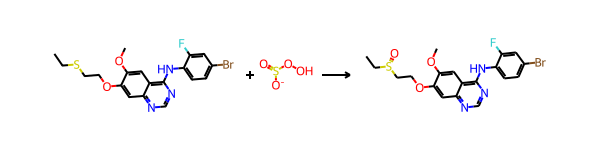

In [ ]:
from rdkit.Chem import rdChemReactions
rxn = rdChemReactions.ReactionFromSmarts(df['reactions'][413], useSmiles=True)
rxn

In [ ]:
dict_smiles = {'formula', 'smiles'}

In [ ]:
database= []

Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]
Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]
Entry with formula 'H2O' and smiles 'O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]


[16:01:25] SMILES Parse Error: syntax error while parsing: Invalid
[16:01:25] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[16:01:25] SMILES Parse Error: syntax error while parsing: Invalid
[16:01:25] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[16:01:25] SMILES Parse Error: syntax error while parsing: Invalid
[16:01:25] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


In [229]:
invalid_entries

[{'formula': 'Invalid', 'smiles': 'Invalid'}]

In [219]:
# With an existing list of dictionaries
existing_database = [{'formula': 'H2O', 'smiles': 'O'}]
db = RSMIDataImpute(existing_database)
db.add_entry('CO2', 'O=C=O')

Entry with formula 'CO2' and smiles 'O=C=O' added to the database.


True

In [235]:
existing_database_1 = [{'formula': 'H2', 'smiles': '[HH]'}]
db = RSMIDataImpute(existing_database)
db.add_entry('H+', '[H+]')

Entry with formula 'H+' and smiles '[H+]' added to the database.


In [237]:
db.add_entry('Li+', '[Li+]')

Entry with formula 'Li+' and smiles '[Li+]' added to the database.


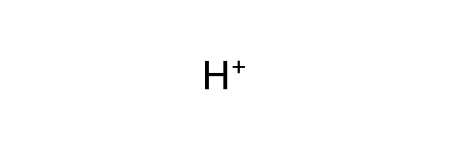

In [224]:
Chem.MolFromSmiles('[H+]')

In [192]:
db.add_entry('CO2', 'C=O')

Entry with smiles 'C=O' already exists in the database.


False

In [185]:
# With an existing list of dictionaries
existing_database = [{'formula': 'H2O', 'smiles': 'O'}]
db = RSMIDataImpute(existing_database)
db.add_entry('CO2', 'C=O')

# With an existing pandas DataFrame
existing_dataframe = pd.DataFrame([{'formula': 'H2O', 'smiles': 'O'}])
db = RSMIDataImpute(existing_dataframe)
db.add_entry('CO2', 'C=O')

# Without an existing database
db = RSMIDataImpute()
db.add_entry('H2O', 'O')


Entry with formula 'CO2' and smiles 'C=O' added to the database.
Entry with formula 'CO2' and smiles 'C=O' added to the database.
Entry with formula 'H2O' and smiles 'O' added to the database.


True

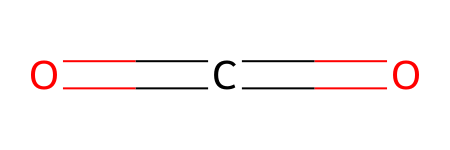

In [189]:
Chem.MolFromSmiles('O=C=O')

In [174]:
database.append(dict)

In [175]:
database

[{'formula': 'HCl', 'smiles': '[Cl]'}]

In [146]:
database= add_smiles_name(formula='HCl', smiles='[Cl]', database=database)

In [147]:
database

In [122]:
dict_smiles

{'formula': ['HF', 'HCl', 'HCl'], 'smiles': ['', '[F]', '[Cl]', '[Cl]']}

In [48]:
pd.DataFrame(dict_smiles)

,formula,smiles


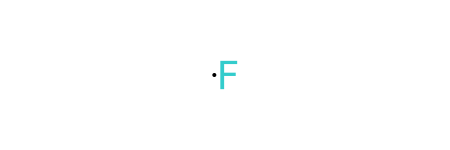

In [103]:
Chem.MolFromSmiles('[F]')

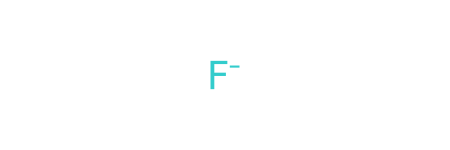

In [101]:
Chem.MolFromSmiles('[F-]')

In [90]:
Chem.MolFromSmiles(['Na+'])

TypeError: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<wchar_t, std::__1::char_traits<wchar_t>, std::__1::allocator<wchar_t> > from this Python object of type list

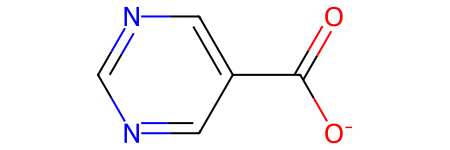

In [100]:
Chem.MolFromSmiles('c1ncncc1C(=O)[O-]')

In [208]:
import rdkit
from rdkit import Chem

def can_break_into_single_ions(smiles):
    # Convert the SMILES string to a Chem.Mol object
    mol = Chem.MolFromSmiles(smiles)

    # Check if the molecule has multiple fragments
    fragments = Chem.GetMolFrags(mol, asMols=True)
    if len(fragments) == 1:
        return False

    # Check if each fragment is an ion
    for frag in fragments:
        if frag.GetNumHs() != 0:
            return False

    # If all fragments are ions, the molecule can break into single ions
    return True


In [211]:
can_break_into_single_ions(['NaOH'])

TypeError: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<wchar_t, std::__1::char_traits<wchar_t>, std::__1::allocator<wchar_t> > from this Python object of type list

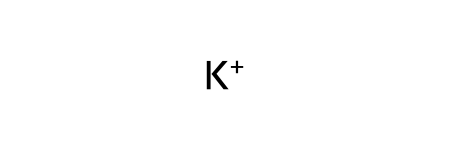

In [217]:
Chem.MolFromSmiles('[K+]')

In [207]:
from rdkit.Chem import FragTypes

ImportError: cannot import name 'FragTypes' from 'rdkit.Chem' (/opt/homebrew/Caskroom/miniforge/base/envs/cheminfo/lib/python3.10/site-packages/rdkit/Chem/__init__.py)